h1 type uint8
r_h1 type: uint8
r_w1 type: uint8
gr1 type: uint8
frw11 type :  float64
eferw1 float64 (512, 512)
w1 float64


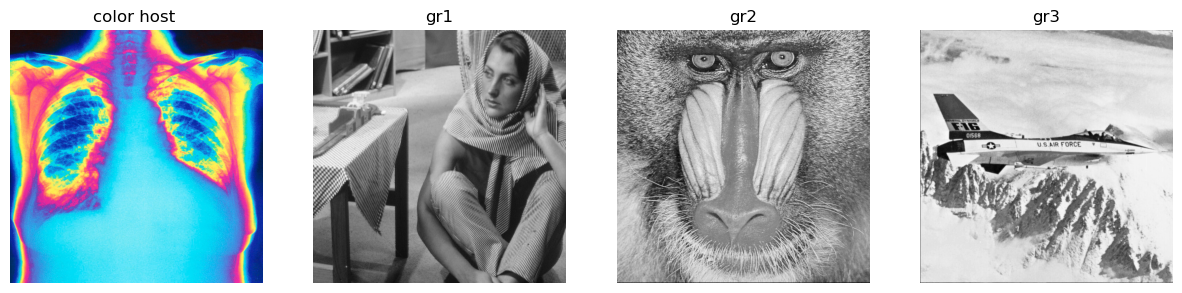

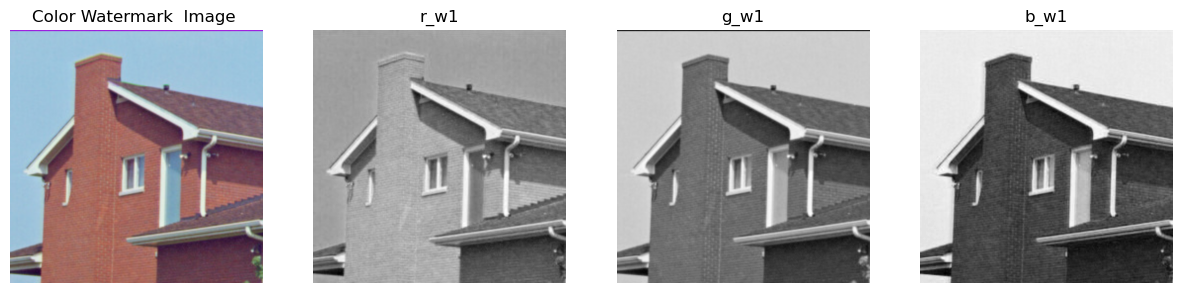

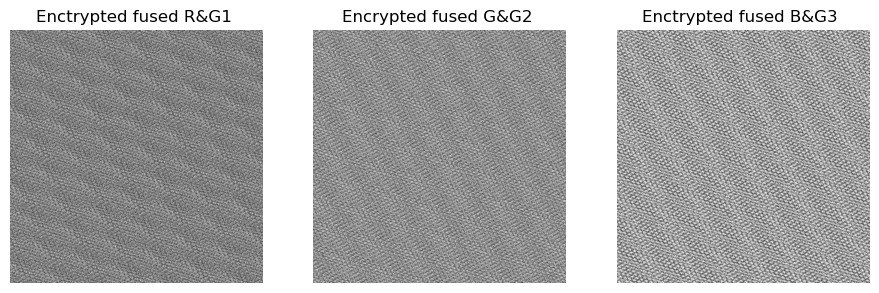

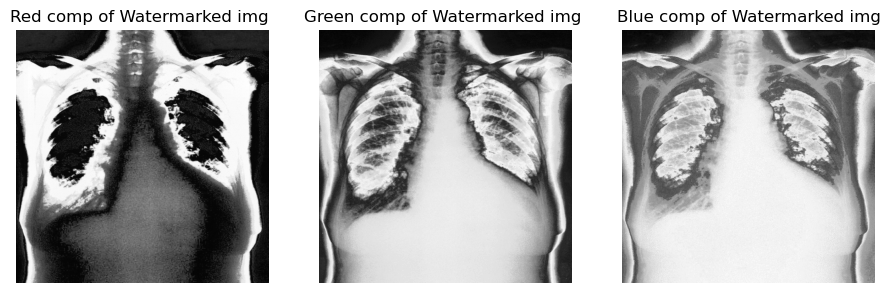

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
from numpy.linalg import svd
from scipy.ndimage import rotate



# Wavelet Based Fusion
def dwt_fusion(image, watermark):
    # Apply DWT to both the image and the watermark
    image_coeffs = pywt.wavedec2(image, 'haar', level=1)
    watermark_coeffs = pywt.wavedec2(watermark, 'haar', level=1)

    # Embed the watermark into all subbands of the DWT coefficients
    alpha = 1.2  # Embedding strength
    fused_coeffs = []
    for i_c, w_c in zip(image_coeffs, watermark_coeffs):
        if isinstance(i_c, tuple):  # If it's a tuple of subbands (e.g., (LH, HL, HH))
            fused_coeffs.append(tuple(ic + alpha * wc for ic, wc in zip(i_c, w_c)))
        else:  # If it's the approximation coefficients
            fused_coeffs.append(i_c + alpha * w_c)

    # Reconstruct the fused image
    fused_image = pywt.waverec2(fused_coeffs, 'haar')
    return fused_image


def dwt_anti_fusion(fused_image, original_image):
    # Apply DWT to both the fused image and the original image
    fused_coeffs = pywt.wavedec2(fused_image, 'haar', level=1)
    original_coeffs = pywt.wavedec2(original_image, 'haar', level=1)

    # Extract the watermark coefficients
    alpha = 1.2  # Embedding strength
    extracted_coeffs = []
    for f_c, o_c in zip(fused_coeffs, original_coeffs):
        if isinstance(f_c, tuple):  # If it's a tuple of subbands (e.g., (LH, HL, HH))
            extracted_coeffs.append(tuple((fc - oc) / alpha for fc, oc in zip(f_c, o_c)))
        else:  # If it's the approximation coefficients
            extracted_coeffs.append((f_c - o_c) / alpha)

    # Reconstruct the watermark
    extracted_watermark = pywt.waverec2(extracted_coeffs, 'haar')
    return extracted_watermark



# SVD
def apply_svd(image):
    U, S, Vt = svd(image, full_matrices=False)
    return U, S, Vt


# ----------------------------------encryption Section -----------------------------------------------------

def arnold_transform(image, iterations, N):
    
    scrambled = image.copy()
    for _ in range(iterations):
        temp = np.zeros_like(scrambled)
        for x in range(N):
            for y in range(N):
                new_x = (x + y) % N
                new_y = (x + 2 * y) % N
                temp[new_x, new_y] = scrambled[x, y]
        scrambled = temp
    return scrambled

def inverse_arnold_transform(image, iterations, N):
   
    descrambled = image.copy()
    for _ in range(iterations):
        temp = np.zeros_like(descrambled)
        for x in range(N):
            for y in range(N):
                new_x = (2 * x - y) % N
                new_y = (-x + y) % N
                temp[new_x, new_y] = descrambled[x, y]
        descrambled = temp
    return descrambled

def block_scrambling(image, block_size, iterations):
    
    H, W = image.shape[:2]
    scrambled = image.copy()
    blocks = [
        scrambled[i:i+block_size, j:j+block_size]
        for i in range(0, H, block_size)
        for j in range(0, W, block_size)
    ]
    N = int(np.sqrt(len(blocks)))
    block_positions = np.arange(len(blocks)).reshape(N, N)
    for _ in range(iterations):
        temp_positions = np.zeros_like(block_positions)
        for x in range(N):
            for y in range(N):
                new_x = (x + y) % N
                new_y = (x + 2 * y) % N
                temp_positions[new_x, new_y] = block_positions[x, y]
        block_positions = temp_positions
    scrambled_blocks = [blocks[idx] for idx in block_positions.flatten()]
    scrambled_image = np.zeros_like(image)
    idx = 0
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            scrambled_image[i:i+block_size, j:j+block_size] = scrambled_blocks[idx]
            idx += 1
    return scrambled_image

def block_descrambling(image, block_size, iterations):
    
    H, W = image.shape[:2]
    scrambled = image.copy()
    blocks = [
        scrambled[i:i+block_size, j:j+block_size]
        for i in range(0, H, block_size)
        for j in range(0, W, block_size)
    ]
    N = int(np.sqrt(len(blocks)))
    block_positions = np.arange(len(blocks)).reshape(N, N)
    for _ in range(iterations):
        temp_positions = np.zeros_like(block_positions)
        for x in range(N):
            for y in range(N):
                new_x = (2 * x - y) % N
                new_y = (-x + y) % N
                temp_positions[new_x, new_y] = block_positions[x, y]
        block_positions = temp_positions
    scrambled_blocks = [blocks[idx] for idx in block_positions.flatten()]
    scrambled_image = np.zeros_like(image)
    idx = 0
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            scrambled_image[i:i+block_size, j:j+block_size] = scrambled_blocks[idx]
            idx += 1
    return scrambled_image


def correlation_coefficient(img1,img2, title= 'Correlation coefficient :'):
    img1 = img1.flatten()
    img2 = img2.flatten()
    corr = np.corrcoef(img1, img2)[0, 1]
    print(title, corr)
    return corr


# ------------------------input images ---------------------------------------------------------------

# color host image
h = cv2.resize(cv2.imread('project_assets/chest.jpg', cv2.IMREAD_COLOR), (512,512)) 
h1 = cv2.cvtColor(h, cv2.COLOR_BGR2RGB) # h1 is the original color host medical image
print('h1 type',h1.dtype)

#RGB components of color host image
r_h1, g_h1, b_h1 = cv2.split(h1) 

print('r_h1 type:', r_h1.dtype)


# Color Watermark image
w = cv2.resize(cv2.imread('project_assets/house.jpg', cv2.IMREAD_COLOR), (512,512)) 
w1 = cv2.cvtColor(w, cv2.COLOR_BGR2RGB)
gray_w1 = cv2.cvtColor(w1, cv2.COLOR_RGB2GRAY)
#RGB components of ColorWatermarkImage1
r_w1, g_w1, b_w1 = cv2.split(w1)

print('r_w1 type:', r_w1.dtype)


# 3 input grayScale images
gr2 = cv2.resize(cv2.imread('project_assets/monkey.jpg', cv2.IMREAD_GRAYSCALE), (512,512)) 
gr1 = cv2.resize(cv2.imread('project_assets/women_sitting.jpg', cv2.IMREAD_GRAYSCALE), (512,512)) 
gr3 = cv2.resize(cv2.imread('project_assets/plane.jpg', cv2.IMREAD_GRAYSCALE), (512,512)) 

print('gr1 type:', gr1.dtype)


#fusion of RGB components of ColorWatermarkImage with three different Grayscale images

# fusion of red component of watermark image with the Grayscale image1
frw11 = dwt_fusion(gr1, r_w1) 
# fusion of green component of watermark image with the Grayscale image2
fgw22 = dwt_fusion(gr2, g_w1) 
# fusion of blue component of watermark image with the Grayscale image3
fbw33 = dwt_fusion(gr3, b_w1) 

print("frw11 type : ", frw11.dtype)


# -----------------------------------------enctyption section  -------------
# Parameters
N = fgw22.shape[0] # keeping it as constant as the dimensions of the every image is same 
pixel_iterations = 11
block_iterations = 4
block_size = 64

# # encrypting the three fused images
efrw = block_scrambling(frw11, block_size, block_iterations)
efrw1 = arnold_transform(efrw, pixel_iterations, N) # efrw1 is encrypted form of - fused image made of red component of watermark and Grayscale image1

efgw2 = block_scrambling(fgw22, block_size, block_iterations)
efgw2 = arnold_transform(efgw2, pixel_iterations, N)

efbw3 = block_scrambling(fbw33, block_size, block_iterations)
efbw3 = arnold_transform(efbw3, pixel_iterations, N)

print('eferw1', efrw1.dtype, efrw1.shape)


# --------------- Various attacks Simulations ----------------------------------

# Crop attack 
top_left = (250, 250)  # Start of the cropping area
bottom_right = (290, 290)  # End of the cropping area// 12.5% for 125x255

# efrw1 = crop_image(efrw1, top_left, bottom_right)
# efgw2 = crop_image(efgw2, top_left, bottom_right)
# efbw3 = crop_image(efbw3, top_left, bottom_right)

#gaussian Noise 




# DWT upto 3rd level and coeffs of the encrypted images and the color host image 
# DWT coeffs of the three  encrypted fused images  
coeffs_er = pywt.wavedec2(efrw1, 'haar', level=3)
cA3er, (cH3er, cV3er, cD3er), (cH2er, cV2er, cD2er), (cH1er, cV1er, cD1er) = coeffs_er
# cA3er is the approximation coefficients matrix at level 3 of the decomposition. of encrypted fused red  

coeffs_eg = pywt.wavedec2(efgw2, 'haar', level=3)
cA3eg, (cH3eg, cV3eg, cD3eg), (cH2eg, cV2eg, cD2eg), (cH1eg, cV1eg, cD1eg) = coeffs_eg

coeffs_eb = pywt.wavedec2(efbw3, 'haar', level=3)
cA3eb, (cH3eb, cV3eb, cD3eb), (cH2eb, cV2eb, cD2eb), (cH1eb, cV1eb, cD1eb) = coeffs_eb


# DWT coeffs of RGB components color host image
coeffs_r = pywt.wavedec2(r_h1, 'haar', level=3)
cA3r, (cH3r, cV3r, cD3r), (cH2r, cV2r, cD2r), (cH1r, cV1r, cD1r) = coeffs_r

coeffs_g = pywt.wavedec2(g_h1, 'haar', level=3)
cA3g, (cH3g, cV3g, cD3g), (cH2g, cV2g, cD2g), (cH1g, cV1g, cD1g) = coeffs_g

coeffs_b = pywt.wavedec2(b_h1, 'haar', level=3)
cA3b, (cH3b, cV3b, cD3b), (cH2b, cV2b, cD2b), (cH1b, cV1b, cD1b) = coeffs_b


# --------------------SVD on cA3, (cH3, cV3, cD3) -------------------------
alpha=0.01
# ------modification of coefficients of red component host with encrypted fused red component ------------------

U_cA3r, S_cA3r, Vt_cA3r = apply_svd(cA3r) # SVD of 3level DWT approximation coeffieient of Host Image 
U_cA3er, S_cA3er, Vt_cA3er = apply_svd(cA3er) # SVD of 3level DWT approximation coeffieient of encrypted fused red component of watermark 
S_cA3_r = S_cA3r + alpha * S_cA3er # modifying the singular value 
# Modified coeffient  
cA3wr = np.dot(U_cA3r, np.dot(np.diag(S_cA3_r), Vt_cA3r)) # Matrix Multiplication

# modification of cH3r
U_cH3r, S_cH3r, Vt_cH3r = apply_svd(cH3r)
U_cH3er, S_cH3er, Vt_cH3er = apply_svd(cH3er)
S_cH3_r = S_cH3r + alpha * S_cH3er
cH3wr = np.dot(U_cH3r, np.dot(np.diag(S_cH3_r), Vt_cH3r))

U_cV3r, S_cV3r, Vt_cV3r = apply_svd(cV3r)
U_cV3er, S_cV3er, Vt_cV3er = apply_svd(cV3er)
S_cV3_r = S_cV3r + alpha * S_cV3er
cV3wr = np.dot(U_cV3r, np.dot(np.diag(S_cV3_r), Vt_cV3r))

U_cD3r, S_cD3r, Vt_cD3r = apply_svd(cD3r)
U_cD3er, S_cD3er, Vt_cD3er = apply_svd(cD3er)
S_cD3_r = S_cD3r + alpha * S_cD3er
cD3wr = np.dot(U_cD3r, np.dot(np.diag(S_cD3_r), Vt_cD3r))



U_cH2r, S_cH2r, Vt_cH2r = apply_svd(cH2r)
U_cH2er, S_cH2er, Vt_cH2er = apply_svd(cH2er)
S_cH2_r = S_cH2r + alpha * S_cH2er
cH2wr = np.dot(U_cH2r, np.dot(np.diag(S_cH2_r), Vt_cH2r))

U_cV2r, S_cV2r, Vt_cV2r = apply_svd(cV2r)
U_cV2er, S_cV2er, Vt_cV2er = apply_svd(cV2er)
S_cV2_r = S_cV2r + alpha * S_cV2er
cV2wr = np.dot(U_cV2r, np.dot(np.diag(S_cV2_r), Vt_cV2r))

U_cD2r, S_cD2r, Vt_cD2r = apply_svd(cD2r)
U_cD2er, S_cD2er, Vt_cD2er = apply_svd(cD2er)
S_cD2_r = S_cD2r + alpha * S_cD2er
cD2wr = np.dot(U_cD2r, np.dot(np.diag(S_cD2_r), Vt_cD2r))



U_cH1r, S_cH1r, Vt_cH1r = apply_svd(cH1r)
U_cH1er, S_cH1er, Vt_cH1er = apply_svd(cH1er)
S_cH1_r = S_cH1r + alpha * S_cH1er
cH1wr = np.dot(U_cH1r, np.dot(np.diag(S_cH1_r), Vt_cH1r))

U_cV1r, S_cV1r, Vt_cV1r = apply_svd(cV1r)
U_cV1er, S_cV1er, Vt_cV1er = apply_svd(cV1er)
S_cV1_r = S_cV1r + alpha * S_cV1er
cV1wr = np.dot(U_cV1r, np.dot(np.diag(S_cV1_r), Vt_cV1r))

U_cD1r, S_cD1r, Vt_cD1r = apply_svd(cD1r)
U_cD1er, S_cD1er, Vt_cD1er = apply_svd(cD1er)
S_cD1_r = S_cD1r + alpha * S_cD1er
cD1wr = np.dot(U_cD1r, np.dot(np.diag(S_cD1_r), Vt_cD1r))


# ------modification of coefficients of green component host with encrypted fused green component ------------------
# green
U_cA3g, S_cA3g, Vt_cA3g = apply_svd(cA3g)
U_cA3eg, S_cA3eg, Vt_cA3eg = apply_svd(cA3eg)
S_cA3_g = S_cA3g + alpha * S_cA3eg
cA3wg = np.dot(U_cA3g, np.dot(np.diag(S_cA3_g), Vt_cA3g))
cA3wg = np.dot(U_cA3g, np.dot(np.diag(S_cA3_g), Vt_cA3g))
# cA3wg = construct_watermarked_image(U_cA3g, S_cA3g, Vt_cA3g, S_cA3eg, alpha=0.01)

U_cH3g, S_cH3g, Vt_cH3g = apply_svd(cH3g)
U_cH3eg, S_cH3eg, Vt_cH3eg = apply_svd(cH3eg)
S_cH3_g = S_cH3g + alpha * S_cH3eg
cH3wg = np.dot(U_cH3g, np.dot(np.diag(S_cH3_g), Vt_cH3g))
# cH3wg = construct_watermarked_image(U_cH3g, S_cH3g, Vt_cH3g, S_cH3eg, alpha=0.01)

U_cV3g, S_cV3g, Vt_cV3g = apply_svd(cV3g)
U_cV3eg, S_cV3eg, Vt_cV3eg = apply_svd(cV3eg)
S_cV3_g = S_cV3g + alpha * S_cV3eg
cV3wg = np.dot(U_cV3g, np.dot(np.diag(S_cV3_g), Vt_cV3g))
# cV3wg = construct_watermarked_image(U_cV3g, S_cV3g, Vt_cV3g, S_cV3eg, alpha=0.01)

U_cD3g, S_cD3g, Vt_cD3g = apply_svd(cD3g)
U_cD3eg, S_cD3eg, Vt_cD3eg = apply_svd(cD3eg)
S_cD3_g = S_cD3g + alpha * S_cD3eg
cD3wg = np.dot(U_cD3g, np.dot(np.diag(S_cD3_g), Vt_cD3g))
# cD3wg = construct_watermarked_image(U_cD3g, S_cD3g, Vt_cD3g, S_cD3eg, alpha=0.01)



U_cH2g, S_cH2g, Vt_cH2g = apply_svd(cH2g)
U_cH2eg, S_cH2eg, Vt_cH2eg = apply_svd(cH2eg)
S_cH2_g = S_cH2g + alpha * S_cH2eg
cH2wg = np.dot(U_cH2g, np.dot(np.diag(S_cH2_g), Vt_cH2g))
# cH2wg = construct_watermarked_image(U_cH2g, S_cH2g, Vt_cH2g, S_cH2eg, alpha=0.01)

U_cV2g, S_cV2g, Vt_cV2g = apply_svd(cV2g)
U_cV2eg, S_cV2eg, Vt_cV2eg = apply_svd(cV2eg)
S_cV2_g = S_cV2g + alpha * S_cV2eg
cV2wg = np.dot(U_cV2g, np.dot(np.diag(S_cV2_g), Vt_cV2g))
# cV2wg = construct_watermarked_image(U_cV2g, S_cV2g, Vt_cV2g, S_cV2eg, alpha=0.01)

U_cD2g, S_cD2g, Vt_cD2g = apply_svd(cD2g)
U_cD2eg, S_cD2eg, Vt_cD2eg = apply_svd(cD2eg)
S_cD2_g = S_cD2g + alpha * S_cD2eg
cD2wg = np.dot(U_cD2g, np.dot(np.diag(S_cD2_g), Vt_cD2g))
# cD2wg = construct_watermarked_image(U_cD2g, S_cD2g, Vt_cD2g, S_cD2eg, alpha=0.01)



U_cH1g, S_cH1g, Vt_cH1g = apply_svd(cH1g)
U_cH1eg, S_cH1eg, Vt_cH1eg = apply_svd(cH1eg)
S_cH1_g = S_cH1g + alpha * S_cH1eg
cH1wg = np.dot(U_cH1g, np.dot(np.diag(S_cH1_g), Vt_cH1g))
# cH1wg = construct_watermarked_image(U_cH1g, S_cH1g, Vt_cH1g, S_cH1eg, alpha=0.01)

U_cV1g, S_cV1g, Vt_cV1g = apply_svd(cV1g)
U_cV1eg, S_cV1eg, Vt_cV1eg = apply_svd(cV1eg)
S_cV1_g = S_cV1g + alpha * S_cV1eg
cV1wg = np.dot(U_cV1g, np.dot(np.diag(S_cV1_g), Vt_cV1g))
# cV1wg = construct_watermarked_image(U_cV1g, S_cV1g, Vt_cV1g, S_cV1eg, alpha=0.01)

U_cD1g, S_cD1g, Vt_cD1g = apply_svd(cD1g)
U_cD1eg, S_cD1eg, Vt_cD1eg = apply_svd(cD1eg)
S_cD1_g = S_cD1g + alpha * S_cD1eg
cD1wg = np.dot(U_cD1g, np.dot(np.diag(S_cD1_g), Vt_cD1g))
# cD1wg = construct_watermarked_image(U_cD1g, S_cD1g, Vt_cD1g, S_cD1eg, alpha=0.01)


# ------modification of coefficients of blue component host with encrypted fused blue component ------------------
# blue
U_cA3b, S_cA3b, Vt_cA3b = apply_svd(cA3b)
U_cA3eb, S_cA3eb, Vt_cA3eb = apply_svd(cA3eb)
S_cA3_b = S_cA3b + alpha * S_cA3eb
cA3wb = np.dot(U_cA3b, np.dot(np.diag(S_cA3_b), Vt_cA3b))
# Reconstruct the watermarked image using the modified singular values
cA3wb = np.dot(U_cA3b, np.dot(np.diag(S_cA3_b), Vt_cA3b))
# cA3wb = construct_watermarked_image(U_cA3b, S_cA3b, Vt_cA3b, S_cA3eb, alpha=0.01)

U_cH3b, S_cH3b, Vt_cH3b = apply_svd(cH3b)
U_cH3eb, S_cH3eb, Vt_cH3eb = apply_svd(cH3eb)
S_cH3_b = S_cH3b + alpha * S_cH3eb
cH3wb = np.dot(U_cH3b, np.dot(np.diag(S_cH3_b), Vt_cH3b))
# cH3wb = construct_watermarked_image(U_cH3b, S_cH3b, Vt_cH3b, S_cH3eb, alpha=0.01)

U_cV3b, S_cV3b, Vt_cV3b = apply_svd(cV3b)
U_cV3eb, S_cV3eb, Vt_cV3eb = apply_svd(cV3eb)
S_cV3_b = S_cV3b + alpha * S_cV3eb
cV3wb = np.dot(U_cV3b, np.dot(np.diag(S_cV3_b), Vt_cV3b))
# cV3wb = construct_watermarked_image(U_cV3b, S_cV3b, Vt_cV3b, S_cV3eb, alpha=0.01)

U_cD3b, S_cD3b, Vt_cD3b = apply_svd(cD3b)
U_cD3eb, S_cD3eb, Vt_cD3eb = apply_svd(cD3eb)
S_cD3_b = S_cD3b + alpha * S_cD3eb
cD3wb = np.dot(U_cD3b, np.dot(np.diag(S_cD3_b), Vt_cD3b))
# cD3wb = construct_watermarked_image(U_cD3b, S_cD3b, Vt_cD3b, S_cD3eb, alpha=0.01)



U_cH2b, S_cH2b, Vt_cH2b = apply_svd(cH2b)
U_cH2eb, S_cH2eb, Vt_cH2eb = apply_svd(cH2eb)
S_cH2_b = S_cH2b + alpha * S_cH2eb
cH2wb = np.dot(U_cH2b, np.dot(np.diag(S_cH2_b), Vt_cH2b))
# cH2wb = construct_watermarked_image(U_cH2b, S_cH2b, Vt_cH2b, S_cH2eb, alpha=0.01)

U_cV2b, S_cV2b, Vt_cV2b = apply_svd(cV2b)
U_cV2eb, S_cV2eb, Vt_cV2eb = apply_svd(cV2eb)
S_cV2_b = S_cV2b + alpha * S_cV2eb
cV2wb = np.dot(U_cV2b, np.dot(np.diag(S_cV2_b), Vt_cV2b))
# cV2wb = construct_watermarked_image(U_cV2b, S_cV2b, Vt_cV2b, S_cV2eb, alpha=0.01)

U_cD2b, S_cD2b, Vt_cD2b = apply_svd(cD2b)
U_cD2eb, S_cD2eb, Vt_cD2eb = apply_svd(cD2eb)
S_cD2_b = S_cD2b + alpha * S_cD2eb
cD2wb = np.dot(U_cD2b, np.dot(np.diag(S_cD2_b), Vt_cD2b))
# cD2wb = construct_watermarked_image(U_cD2b, S_cD2b, Vt_cD2b, S_cD2eb, alpha=0.01)



U_cH1b, S_cH1b, Vt_cH1b = apply_svd(cH1b)
U_cH1eb, S_cH1eb, Vt_cH1eb = apply_svd(cH1eb)
S_cH1_b = S_cH1b + alpha * S_cH1eb
cH1wb = np.dot(U_cH1b, np.dot(np.diag(S_cH1_b), Vt_cH1b))
# cH1wb = construct_watermarked_image(U_cH1b, S_cH1b, Vt_cH1b, S_cH1eb, alpha=0.01)

U_cV1b, S_cV1b, Vt_cV1b = apply_svd(cV1b)
U_cV1eb, S_cV1eb, Vt_cV1eb = apply_svd(cV1eb)
S_cV1_b = S_cV1b + alpha * S_cV1eb
cV1wb = np.dot(U_cV1b, np.dot(np.diag(S_cV1_b), Vt_cV1b))
# cV1wb = construct_watermarked_image(U_cV1b, S_cV1b, Vt_cV1b, S_cV1eb, alpha=0.01)

U_cD1b, S_cD1b, Vt_cD1b = apply_svd(cD1b)
U_cD1eb, S_cD1eb, Vt_cD1eb = apply_svd(cD1eb)
S_cD1_b = S_cD1b + alpha * S_cD1eb
cD1wb = np.dot(U_cD1b, np.dot(np.diag(S_cD1_b), Vt_cD1b))
# cD1wb = construct_watermarked_image(U_cD1b, S_cD1b, Vt_cD1b, S_cD1eb, alpha=0.01)


# ----------------------------inverse DWt---------------------
# merging the coefficients 
coeff_rw = cA3wr, (cH3wr, cV3wr, cD3wr), (cH2wr, cV2wr, cD2wr), (cH1wr, cV1wr, cD1wr) 
r_wm = pywt.waverec2(coeff_rw, 'haar')
# r_wm red component of watermarked image

coeff_gw = cA3wg, (cH3wg, cV3wg, cD3wg), (cH2wg, cV2wg, cD2wg), (cH1wg, cV1wg, cD1wg)
g_wm = pywt.waverec2(coeff_gw, 'haar')
# g_wm green component of watermarked image 

coeff_bw = cA3wb, (cH3wb, cV3wb, cD3wb), (cH2wb, cV2wb, cD2wb), (cH1wb, cV1wb, cD1wb)
b_wm = pywt.waverec2(coeff_bw, 'haar')
# b_wm blue component of watermarked image

# merging the three components to form watermarked image 
watermarked_image1 = cv2.merge((r_wm,g_wm,b_wm))
image = watermarked_image1

print('w1',watermarked_image1.dtype)
cv2.imwrite('assets/watermarked_image1.png', watermarked_image1)
watermarrked_image1 = cv2.imread('assets/watermarked_image1.png', cv2.IMREAD_COLOR)


# Visulaisations
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(h1, cmap = 'gray')
plt.title('color host ')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(gr1, cmap = 'gray')
plt.title('gr1')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(gr2, cmap = 'gray')
plt.title('gr2')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(gr3, cmap = 'gray')
plt.title('gr3')
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(w1, cmap = 'gray')
plt.title('Color Watermark  Image ')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(r_w1, cmap = 'gray')
plt.title('r_w1')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(g_w1, cmap = 'gray')
plt.title('g_w1')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(b_w1, cmap = 'gray')
plt.title('b_w1')
plt.axis('off')

plt.show()


plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(efrw1, cmap = 'gray')
plt.title('Enctrypted fused R&G1 ')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(efgw2, cmap = 'gray')
plt.title('Encrypted fused G&G2 ')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(efbw3, cmap = 'gray')
plt.title('Enctrypted fused B&G3 ')
plt.axis('off')

plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(r_wm, cmap = 'gray')
plt.title('Red comp of Watermarked img ')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(g_wm, cmap = 'gray')
plt.title('Green comp of Watermarked img ')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(b_wm, cmap = 'gray')
plt.title('Blue comp of Watermarked img')
plt.axis('off')
plt.show()



Cr of extracted chiphered fused red :  0.9999999999999954
Cr of extracted dechiphered fused red :  0.9999999999999933
Cr of fused ciphered blue :  1.0
Cr of fused deciphere blue :  1.0
Cr of extracted watermark gray :  0.9999967841904237
Cr of extracted Color watermark :  0.9999969656781234


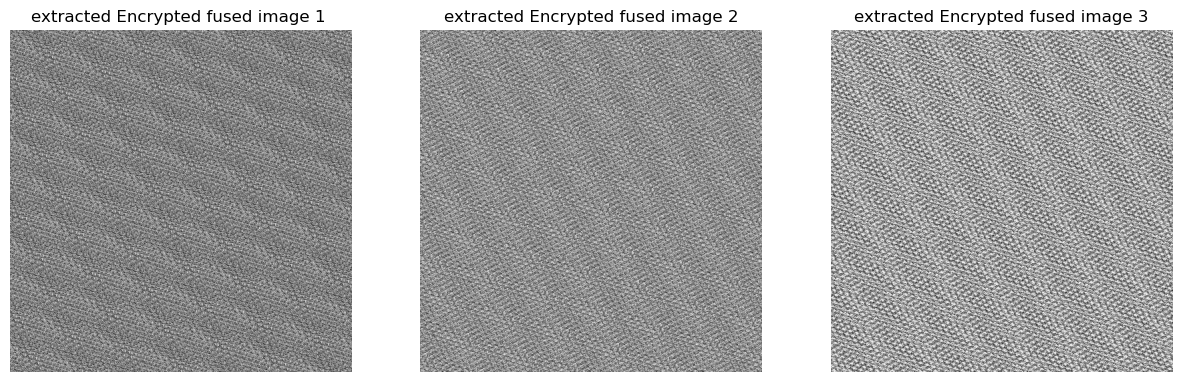

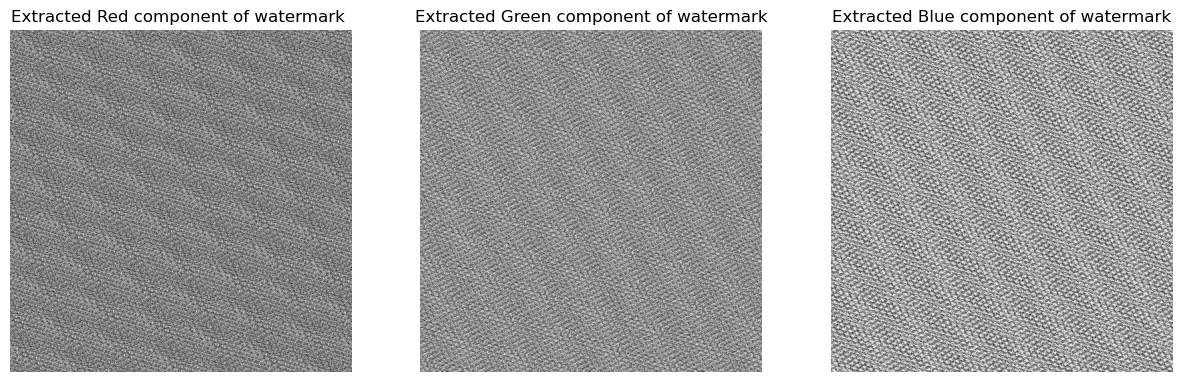

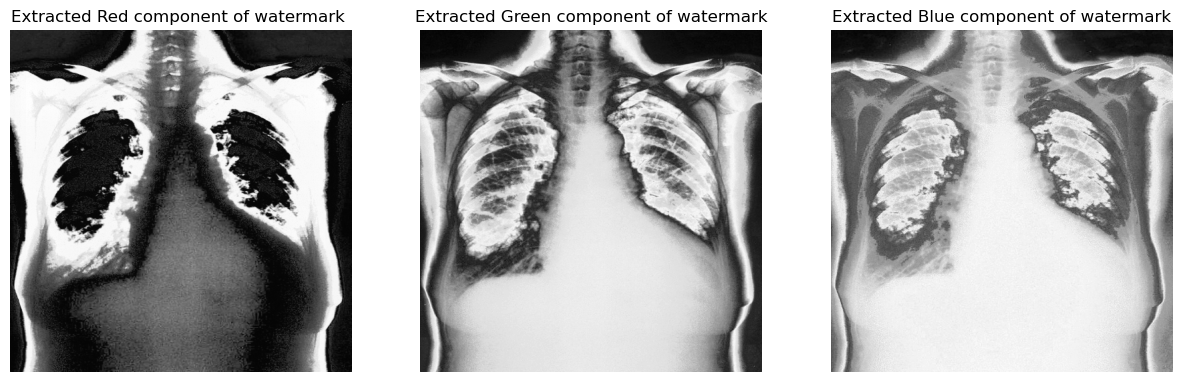

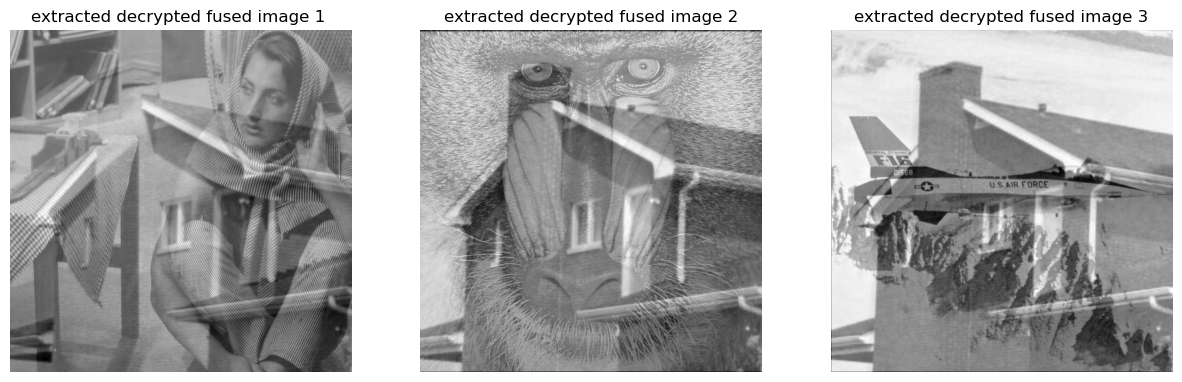

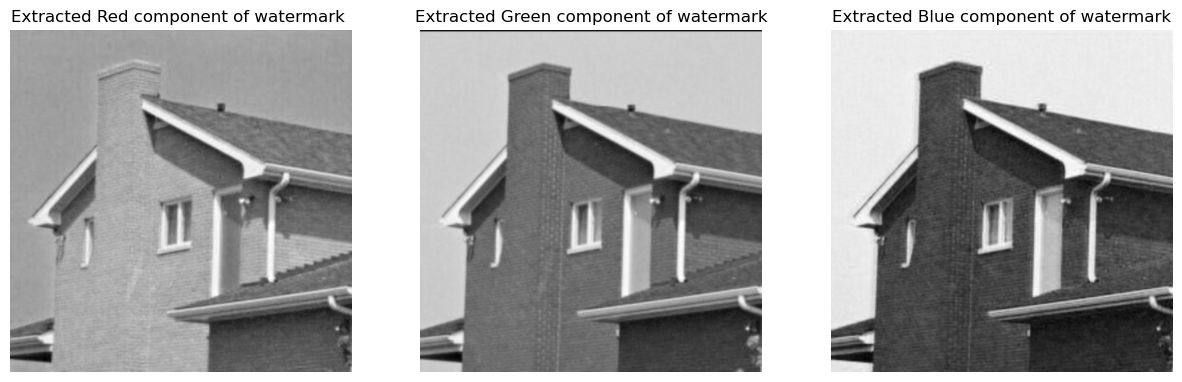

float64


In [2]:
#Extraction Stage 
# watermarked_image2 = watermarked_image2.astype(np.float64)
r_wc, g_wc, b_wc = cv2.split(watermarked_image1)


coeffs_wcr = pywt.wavedec2(r_wc, 'haar', level=3)
cA3wcr, (cH3wcr, cV3wcr, cD3wcr), (cH2wcr, cV2wcr, cD2wcr), (cH1wcr, cV1wcr, cD1wcr) = coeffs_wcr

coeffs_wcg = pywt.wavedec2(g_wc, 'haar', level=3)
cA3wcg, (cH3wcg, cV3wcg, cD3wcg), (cH2wcg, cV2wcg, cD2wcg), (cH1wcg, cV1wcg, cD1wcg) = coeffs_wcg

coeffs_wcb = pywt.wavedec2(b_wc, 'haar', level=3)
cA3wcb, (cH3wcb, cV3wcb, cD3wcb), (cH2wcb, cV2wcb, cD2wcb), (cH1wcb, cV1wcb, cD1wcb) = coeffs_wcb


# svd
U_cA3wcr, S_cA3wcr, Vt_cA3wcr = apply_svd(cA3wcr)
S_cA3_exr = (S_cA3wcr - S_cA3r) / 0.01

U_cH3wcr, S_cH3wcr, Vt_cH3wcr = apply_svd(cH3wcr)
S_cH3_exr = (S_cH3wcr - S_cH3r) / 0.01

U_cV3wcr, S_cV3wcr, Vt_cV3wcr = apply_svd(cV3wcr)
S_cV3_exr = (S_cV3wcr - S_cV3r) / 0.01

U_cD3wcr, S_cD3wcr, Vt_cD3wcr = apply_svd(cD3wcr)
S_cD3_exr = (S_cD3wcr - S_cD3r) / 0.01


U_cH2wcr, S_cH2wcr, Vt_cH2wcr = apply_svd(cH2wcr)
S_cH2_exr = (S_cH2wcr - S_cH2r) / 0.01

U_cV2wcr, S_cV2wcr, Vt_cV2wcr = apply_svd(cV2wcr)
S_cV2_exr = (S_cV2wcr - S_cV2r) / 0.01

U_cD2wcr, S_cD2wcr, Vt_cD2wcr = apply_svd(cD2wcr)
S_cD2_exr = (S_cD2wcr - S_cD2r) / 0.01


U_cH1wcr, S_cH1wcr, Vt_cH1wcr = apply_svd(cH1wcr)
S_cH1_exr = (S_cH1wcr - S_cH1r) / 0.01

U_cV1wcr, S_cV1wcr, Vt_cV1wcr = apply_svd(cV1wcr)
S_cV1_exr = (S_cV1wcr - S_cV1r) / 0.01

U_cD1wcr, S_cD1wcr, Vt_cD1wcr = apply_svd(cD1wcr)
S_cD1_exr = (S_cD1wcr - S_cD1r) / 0.01


cA3exr = np.dot(U_cA3er, np.dot(np.diag(S_cA3_exr), Vt_cA3er))
cH3exr = np.dot(U_cH3er, np.dot(np.diag(S_cH3_exr), Vt_cH3er))
cV3exr = np.dot(U_cV3er, np.dot(np.diag(S_cV3_exr), Vt_cV3er))
cD3exr = np.dot(U_cD3er, np.dot(np.diag(S_cD3_exr), Vt_cD3er))

cH2exr = np.dot(U_cH2er, np.dot(np.diag(S_cH2_exr), Vt_cH2er))
cV2exr = np.dot(U_cV2er, np.dot(np.diag(S_cV2_exr), Vt_cV2er))
cD2exr = np.dot(U_cD2er, np.dot(np.diag(S_cD2_exr), Vt_cD2er))

cH1exr = np.dot(U_cH1er, np.dot(np.diag(S_cH1_exr), Vt_cH1er))
cV1exr = np.dot(U_cV1er, np.dot(np.diag(S_cV1_exr), Vt_cV1er))
cD1exr = np.dot(U_cD1er, np.dot(np.diag(S_cD1_exr), Vt_cD1er))

coeff_exr = cA3exr, (cH3exr, cV3exr, cD3exr), (cH2exr, cV2exr, cD2exr), (cH1exr, cV1exr, cD1exr) 
r_ex = pywt.waverec2(coeff_exr, 'haar')
# r_ex = rotate(r_ex, angle=-15, reshape=False, order=1, mode='constant', cval=0.0, prefilter=False)
# r_ex = r_ex.astype(np.uint8)
# r_dx = np.bitwise_xor(r_ex, keystream1)
Cr_1 = correlation_coefficient(r_ex,efrw1,"Cr of extracted chiphered fused red : ")
r_dx = inverse_arnold_transform(r_ex, pixel_iterations, N)
r_dx = block_descrambling(r_dx, block_size, block_iterations)

Cr_2 = correlation_coefficient(r_dx,frw11,"Cr of extracted dechiphered fused red : ")





# green 
U_cA3wcg, S_cA3wcg, Vt_cA3wcg = apply_svd(cA3wcg)
S_cA3_exg = (S_cA3wcg - S_cA3g) / 0.01

U_cH3wcg, S_cH3wcg, Vt_cH3wcg = apply_svd(cH3wcg)
S_cH3_exg = (S_cH3wcg - S_cH3g) / 0.01

U_cV3wcg, S_cV3wcg, Vt_cV3wcg = apply_svd(cV3wcg)
S_cV3_exg = (S_cV3wcg - S_cV3g) / 0.01

U_cD3wcg, S_cD3wcg, Vt_cD3wcg = apply_svd(cD3wcg)
S_cD3_exg = (S_cD3wcg - S_cD3g) / 0.01


U_cH2wcg, S_cH2wcg, Vt_cH2wcg = apply_svd(cH2wcg)
S_cH2_exg = (S_cH2wcg - S_cH2g) / 0.01

U_cV2wcg, S_cV2wcg, Vt_cV2wcg = apply_svd(cV2wcg)
S_cV2_exg = (S_cV2wcg - S_cV2g) / 0.01

U_cD2wcg, S_cD2wcg, Vt_cD2wcg = apply_svd(cD2wcg)
S_cD2_exg = (S_cD2wcg - S_cD2g) / 0.01


U_cH1wcg, S_cH1wcg, Vt_cH1wcg = apply_svd(cH1wcg)
S_cH1_exg = (S_cH1wcg - S_cH1g) / 0.01

U_cV1wcg, S_cV1wcg, Vt_cV1wcg = apply_svd(cV1wcg)
S_cV1_exg = (S_cV1wcg - S_cV1g) / 0.01

U_cD1wcg, S_cD1wcg, Vt_cD1wcg = apply_svd(cD1wcg)
S_cD1_exg = (S_cD1wcg - S_cD1g) / 0.01



cA3exg = np.dot(U_cA3eg, np.dot(np.diag(S_cA3_exg), Vt_cA3eg))
cH3exg = np.dot(U_cH3eg, np.dot(np.diag(S_cH3_exg), Vt_cH3eg))
cV3exg = np.dot(U_cV3eg, np.dot(np.diag(S_cV3_exg), Vt_cV3eg))
cD3exg = np.dot(U_cD3eg, np.dot(np.diag(S_cD3_exg), Vt_cD3eg))

cH2exg = np.dot(U_cH2eg, np.dot(np.diag(S_cH2_exg), Vt_cH2eg))
cV2exg = np.dot(U_cV2eg, np.dot(np.diag(S_cV2_exg), Vt_cV2eg))
cD2exg = np.dot(U_cD2eg, np.dot(np.diag(S_cD2_exg), Vt_cD2eg))

cH1exg = np.dot(U_cH1eg, np.dot(np.diag(S_cH1_exg), Vt_cH1eg))
cV1exg = np.dot(U_cV1eg, np.dot(np.diag(S_cV1_exg), Vt_cV1eg))
cD1exg = np.dot(U_cD1eg, np.dot(np.diag(S_cD1_exg), Vt_cD1eg))

coeff_exg = cA3exg, (cH3exg, cV3exg, cD3exg), (cH2exg, cV2exg, cD2exg), (cH1exg, cV1exg, cD1exg) 
g_ex = pywt.waverec2(coeff_exg, 'haar')
# g_ex = g_ex.astype(np.uint8)
# g_dx = np.bitwise_xor(g_ex, keystream2)

g_dx = inverse_arnold_transform(g_ex, pixel_iterations, N)
g_dx = block_descrambling(g_dx, block_size, block_iterations)

# blue

U_cA3wcb, S_cA3wcb, Vt_cA3wcb = apply_svd(cA3wcb)
S_cA3_exb = (S_cA3wcb - S_cA3b) / 0.01

U_cH3wcb, S_cH3wcb, Vt_cH3wcb = apply_svd(cH3wcb)
S_cH3_exb = (S_cH3wcb - S_cH3b) / 0.01

U_cV3wcb, S_cV3wcb, Vt_cV3wcb = apply_svd(cV3wcb)
S_cV3_exb = (S_cV3wcb - S_cV3b) / 0.01

U_cD3wcb, S_cD3wcb, Vt_cD3wcb = apply_svd(cD3wcb)
S_cD3_exb = (S_cD3wcb - S_cD3b) / 0.01


U_cH2wcb, S_cH2wcb, Vt_cH2wcb = apply_svd(cH2wcb)
S_cH2_exb = (S_cH2wcb - S_cH2b) / 0.01

U_cV2wcb, S_cV2wcb, Vt_cV2wcb = apply_svd(cV2wcb)
S_cV2_exb = (S_cV2wcb - S_cV2b) / 0.01

U_cD2wcb, S_cD2wcb, Vt_cD2wcb = apply_svd(cD2wcb)
S_cD2_exb = (S_cD2wcb - S_cD2b) / 0.01


U_cH1wcb, S_cH1wcb, Vt_cH1wcb = apply_svd(cH1wcb)
S_cH1_exb = (S_cH1wcb - S_cH1b) / 0.01

U_cV1wcb, S_cV1wcb, Vt_cV1wcb = apply_svd(cV1wcb)
S_cV1_exb = (S_cV1wcb - S_cV1b) / 0.01

U_cD1wcb, S_cD1wcb, Vt_cD1wcb = apply_svd(cD1wcb)
S_cD1_exb = (S_cD1wcb - S_cD1b) / 0.01

cA3exb = np.dot(U_cA3eb, np.dot(np.diag(S_cA3_exb), Vt_cA3eb))
cH3exb = np.dot(U_cH3eb, np.dot(np.diag(S_cH3_exb), Vt_cH3eb))
cV3exb = np.dot(U_cV3eb, np.dot(np.diag(S_cV3_exb), Vt_cV3eb))
cD3exb = np.dot(U_cD3eb, np.dot(np.diag(S_cD3_exb), Vt_cD3eb))

cH2exb = np.dot(U_cH2eb, np.dot(np.diag(S_cH2_exb), Vt_cH2eb))
cV2exb = np.dot(U_cV2eb, np.dot(np.diag(S_cV2_exb), Vt_cV2eb))
cD2exb = np.dot(U_cD2eb, np.dot(np.diag(S_cD2_exb), Vt_cD2eb))

cH1exb = np.dot(U_cH1eb, np.dot(np.diag(S_cH1_exb), Vt_cH1eb))
cV1exb = np.dot(U_cV1eb, np.dot(np.diag(S_cV1_exb), Vt_cV1eb))
cD1exb = np.dot(U_cD1eb, np.dot(np.diag(S_cD1_exb), Vt_cD1eb))

coeff_exb = cA3exb, (cH3exb, cV3exb, cD3exb), (cH2exb, cV2exb, cD2exb), (cH1exb, cV1exb, cD1exb) 
b_ex = pywt.waverec2(coeff_exb, 'haar')
Cr1 = correlation_coefficient(b_ex,efbw3,"Cr of fused ciphered blue : ")

b_dx = inverse_arnold_transform(b_ex, pixel_iterations, N)
b_dx = block_descrambling(b_dx, block_size, block_iterations)
Cr1 = correlation_coefficient(b_dx,fbw33,"Cr of fused deciphere blue : ")

ex_r_wm = dwt_anti_fusion(r_dx, gr1)
ex_g_wm = dwt_anti_fusion(g_dx, gr2)
ex_b_wm = dwt_anti_fusion(b_dx, gr3)


x = cv2.merge((ex_r_wm,ex_g_wm,ex_b_wm))
x = x.astype(np.uint8)
gray_x = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
Cr_3 = correlation_coefficient(gray_x, gray_w1,"Cr of extracted watermark gray : ")
Cr_4 = correlation_coefficient(x,w1,"Cr of extracted Color watermark : ")

# print('x',x.dtype)

# print("cA3wcr", b_ex)
# print("\n\n",efrw1)
# print("cA3wcr", b_ex.dtype)
# print("\n\n",efrw1.dtype)

plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.imshow(efrw1, cmap = 'gray')
plt.title('extracted Encrypted fused image 1 ')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(efgw2, cmap = 'gray')
plt.title('extracted Encrypted fused image 2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(efbw3, cmap = 'gray')
plt.title('extracted Encrypted fused image 3')
plt.axis('off')

plt.show()


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(r_ex, cmap = 'gray')
plt.title('Extracted Red component of watermark ')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(g_ex, cmap = 'gray')
plt.title('Extracted Green component of watermark')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(b_ex, cmap = 'gray')
plt.title('Extracted Blue component of watermark')
plt.axis('off')
plt.show()


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(r_wc, cmap = 'gray')
plt.title('Extracted Red component of watermark ')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(g_wc, cmap = 'gray')
plt.title('Extracted Green component of watermark')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(b_wc, cmap = 'gray')
plt.title('Extracted Blue component of watermark')
plt.axis('off')
plt.show()


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(r_dx, cmap = 'gray')
plt.title('extracted decrypted fused image 1 ')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(g_dx, cmap = 'gray')
plt.title('extracted decrypted fused image 2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(b_dx, cmap = 'gray')
plt.title('extracted decrypted fused image 3')
plt.axis('off')
plt.show()


plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.imshow(ex_r_wm, cmap = 'gray')
plt.title('Extracted Red component of watermark ')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(ex_g_wm, cmap = 'gray')
plt.title('Extracted Green component of watermark')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(ex_b_wm, cmap = 'gray')
plt.title('Extracted Blue component of watermark')
plt.axis('off')

plt.show()

print(frw11.dtype)

In [3]:
import numpy as np
import math
import cv2

def calculate_psnr(img1, img2,title):
    # Convert images to float64 for precision
#     img1 = img1.astype(np.float64)
#     img2 = img2.astype(np.float64)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((img1 - img2) ** 2)

    # If MSE is zero, the images are identical
    if mse == 0:
        return float('inf')  # Infinite PSNR for identical images

    # Maximum possible pixel value (for 8-bit images)
    max_pixel = 255.0

    # Calculate PSNR
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    print(title,psnr)
    


def calculate_ssim(img1, img2, C1=6.5025, C2=58.5225):
    # Convert images to float64
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    # Calculate means
    mu1 = np.mean(img1)
    mu2 = np.mean(img2)

    # Calculate variances and covariance
    sigma1_sq = np.var(img1)
    sigma2_sq = np.var(img2)
    sigma12 = np.cov(img1.flatten(), img2.flatten())[0][1]

    # Calculate SSIM
    ssim = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / \
            ((mu1**2 + mu2**2 + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim




print("values crop attack , for chest")
ssim = calculate_ssim(w1,x)
print('ssim', ssim)
calculate_psnr(w1, x,'psnr between original and extracted : ')
print("Cr_1: ", Cr_1,'Cr_2: ',Cr_2, 'Cr_3: ', Cr_3, 'Cr_4', Cr_4)

values crop attack , for chest
ssim 0.9999982490308695
psnr between original and extracted :  65.96438234163304
Cr_1:  0.9999999999999954 Cr_2:  0.9999999999999933 Cr_3:  0.9999967841904237 Cr_4 0.9999969656781234
